## Molecular Variational Autoencoders 
as seen in gomez et al.


Additional Resources:

- https://keras.io/examples/generative/molecule_generation/

# Introduction

The goal of drug and material design is to identify novel molecules that have certain desirable properties. We can view this as an optimization problem, in which we are searching for the molecules that maximize our quantitative desiderata. However, optimization in molecular space is extremely challenging, because the search space is large, discrete, and unstructured. Making and testing new compounds are costly and time-consuming, and the number of potential candidates is overwhelming. Only about 108 substances have ever been synthesized, whereas the range of potential drug-like molecules is estimated to be between 1023 and 1060.
Virtual screening can be used to speed up this search. Virtual libraries containing thousands to hundreds of millions of candidates can be assayed with first-principles simulations or statistical predictions based on learned proxy models, and only the most promising leads are selected and tested experimentally.


# AutoEncoders

The autoencoder in comprised of two deep networks: an encoder network to convert each string into a fixed-dimensional vector, and a decoder network to convert vectors back into strings. The autoencoder is trained to minimize error in reproducing the original string; i.e., it attempts to learn the identity function. Key to the design of the autoencoder is the mapping of strings through an information bottleneck. This bottleneck—here the fixed-length continuous vector—induces the network to learn a compressed representation that captures the most statistically salient information in the data. We call the vector-encoded molecule the latent representation of the molecule.

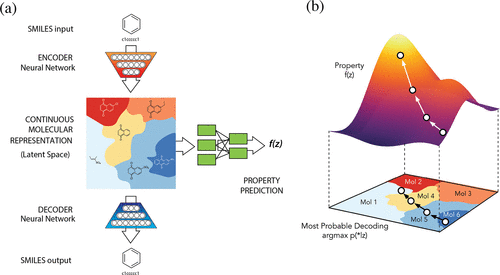

# Variational Autoencoders
AutoEncoders are a good approach to generate a model which can encode and decode vector into a latent space but this method might be useful in dimensionality reduction but for genreative models we cannot just randomly take a point in this latent space and decode it to get a new molecule, for this VAEs are used. *A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.*

In VAEs instead of encoding an input as a single point, we encode it as a distribution over the latent space. The model is then trained as follows:

* first, the input is encoded as distribution over the latent space

* second, a point from the latent space is sampled from that distribution

* third, the sampled point is decoded and the reconstruction error can be computed

* finally, the reconstruction error is backpropagated through the network

## Loss in VAE's

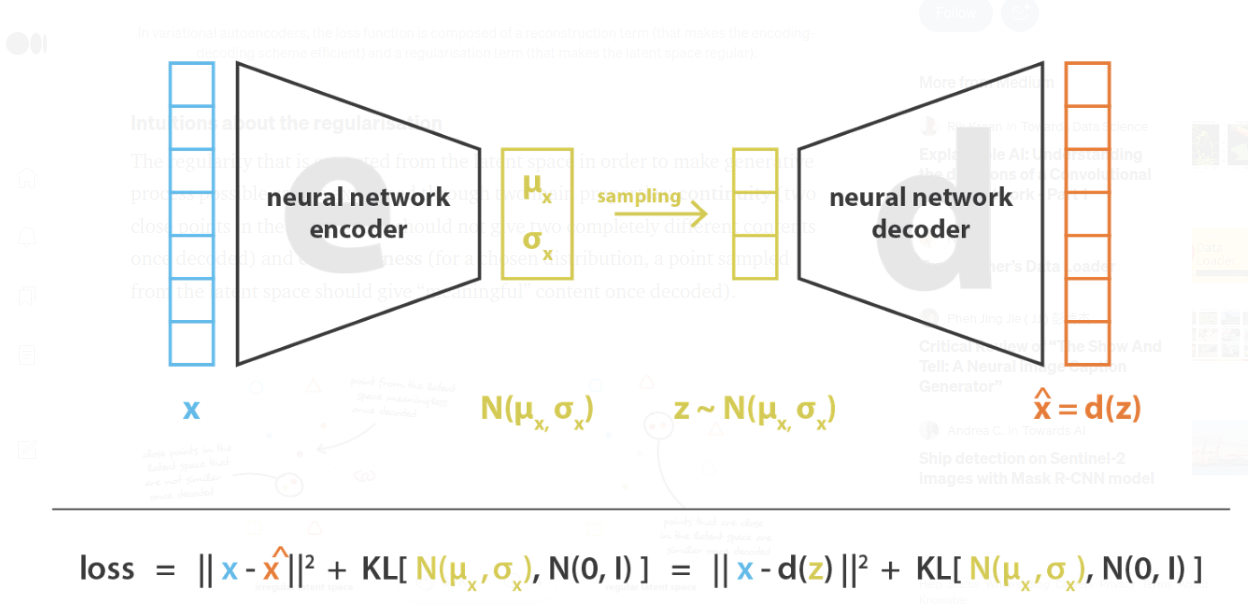

The loss is composed of two terms the "Reonstruction term" and the "Regularization term". That regularisation term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian.

### KL Divergence
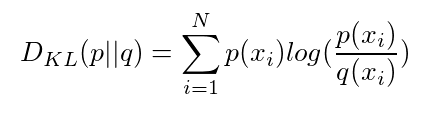

Here q(x) is the approximation and p(x) is the true distribution we’re interested in matching q(x) to. Intuitively this measures the how much a given arbitrary distribution is away from the true distribution. If two distributions perfectly match, KL(p||q) = 0 otherwise it can take values between 0 and ∞. Lower the KL divergence value, the better we have matched the true distribution with our approximation.

***INTUITION***

Let’s look at the KL divergence piece by piece. First take the log(p(x_i)/q(x_i)) component. What happens if q(x_i) is higher than p(x_i)? Then this component will produce a negative value (because log of less than 1 values are negative). On the other hand if q(x_i) is always smaller than p(x_i) this component will produce positive values. This will be zero only if p(x_i)=q(x_i). Then to make this an expected value, you weight the log component with p(x_i). This means that, matching areas where p(x_i) has higher probability is more important than matching areas with low p(x_i) probability.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
from tqdm.auto import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [ ]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in range(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return "".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)


In [ ]:
!unzip processed.zip

Archive:  processed.zip
  inflating: processed.h5            


In [ ]:
class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(70, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 33)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

In [ ]:
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

data_train, data_test, charset = load_dataset('./processed.h5')
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=500, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_test,batch_size = 500)
charset = charset.astype("str")

In [ ]:

torch.manual_seed(0)

epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters())

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in tqdm(enumerate(train_loader), desc="Epoch {}: ".format(epoch), total=len(train_loader)):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)
        
        if batch_idx==0:
              inp = data.cpu().numpy()
              outp = output.cpu().detach().numpy()
              lab = data.cpu().numpy()
              print("Input:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
              print("Label:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
              sampled = outp[0].reshape(1, 120, len(charset)).argmax(axis=2)[0]
              print("Output:")
              print(decode_smiles_from_indexes(sampled, charset))
        
        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()
#         if batch_idx % 100 == 0:
#             print(f'{epoch} / {batch_idx}\t{loss:.4f}')
    print('train', train_loss / len(train_loader.dataset))
    return train_loss / len(train_loader.dataset)

losses = []
for epoch in range(1, 10):
    train_loss = train(epoch)
    losses.append(train_loss)

Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]

Input:
c1ccc2c(c1)n3c(c4n2nnn4)nnn3
Label:
c1ccc2c(c1)n3c(c4n2nnn4)nnn3
Output:
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train tensor(177.4376, device='cuda:0', grad_fn=<DivBackward0>)


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]

Input:
COC(=O)[C@H](Cc1ccccc1Cl)C#N
Label:
COC(=O)[C@H](Cc1ccccc1Cl)C#N
Output:
Ccccccccccccccccccccccccc
train tensor(124.5733, device='cuda:0', grad_fn=<DivBackward0>)


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]

Input:
CC(C)(C)C(=O)OCc1nc(cs1)c2ccc(c(c2)F)F
Label:
CC(C)(C)C(=O)OCc1nc(cs1)c2ccc(c(c2)F)F
Output:
CccccccccccccccccccccccccccccccccccccCC
train tensor(124.0190, device='cuda:0', grad_fn=<DivBackward0>)


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]

Input:
COc1cc(ccc1N)Nc2ccccc2
Label:
COc1cc(ccc1N)Nc2ccccc2
Output:
CCcccccccccccccccccccc


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load("./saved_model.pt"))

<All keys matched successfully>

In [ ]:
inp = data_test[4]
inp = inp[None, :]
inp = torch.FloatTensor(inp)
inp = inp.to(device)

inp_cpu = inp.detach().cpu()
print("Input:")
print(decode_smiles_from_indexes(map(from_one_hot_array, inp_cpu[0]), charset))

output = model(inp)[0]

sampled = output.reshape(1, 120, len(charset)).argmax(axis=2)[0]
print("Output:")
print(decode_smiles_from_indexes(sampled, charset))

Input:
c1cc(ccc1N)S(=O)(=O)N2CCCCC2
Output:
c1cc(ccc1F)S(=O)(=O)N2CCCCC2


In [ ]:
emb = torch.randn((1, 292))

emb = emb.to(device)
out = model.decode(emb)

In [ ]:

output = out[0]

sampled = output.reshape(1, 120, len(charset)).argmax(axis=2)[0]
print("Output:")
print(decode_smiles_from_indexes(sampled, charset))

Output:
c1cc2c(c11C(=O)N333cccccc3CCCCCCCCCCCCCCCCC=C=O
